In [ ]:
!pip install visualkeras pydot pydotplus graphviz

In [ ]:
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tensorflow as tf
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
import visualkeras

DATA_DIR = "/content/american_sign_language.PNG"
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "sign_mnist_train")
TEST_DATA_DIR = os.path.join(DATA_DIR, "sign_mnist_test")
TRAIN_DATA_PATH = os.path.join(TRAIN_DATA_DIR, "/content/sign_mnist_train.csv")
TEST_DATA_PATH = os.path.join(TEST_DATA_DIR, "/content/sign_mnist_test.csv")
RANDOM_SEED = 42
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import os
for dirname, _, filenames in os.walk('/content/american_sign_language.PNG'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("Using device: {}".format(DEVICE))

Using device: cpu


In [ ]:
print(len(TRAIN_DATA_PATH))
print(len(TEST_DATA_PATH))

29
28


In [ ]:
training_data = pd.read_csv(TRAIN_DATA_PATH)
training_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
training_data.shape

(27455, 785)

In [ ]:
testing_data = pd.read_csv(TEST_DATA_PATH)
testing_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
testing_data.shape

(7172, 785)

In [ ]:
np.unique(training_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [ ]:
np.bincount(training_data["label"].values)

array([1126, 1010, 1144, 1196,  957, 1204, 1090, 1013, 1162,    0, 1114,
       1241, 1055, 1151, 1196, 1088, 1279, 1294, 1199, 1186, 1161, 1082,
       1225, 1164, 1118])

In [ ]:
np.unique(testing_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [ ]:
np.bincount(testing_data["label"].values)

array([331, 432, 310, 245, 498, 247, 348, 436, 288,   0, 331, 209, 394,
       291, 246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332])

In [ ]:
def adjust_class_labels(label):

    if label >= 10:
        label -= 1

    return label

In [ ]:
training_data["label"] = training_data["label"].apply(adjust_class_labels)

In [ ]:
np.unique(training_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
np.bincount(training_data["label"].values)

array([1126, 1010, 1144, 1196,  957, 1204, 1090, 1013, 1162, 1114, 1241,
       1055, 1151, 1196, 1088, 1279, 1294, 1199, 1186, 1161, 1082, 1225,
       1164, 1118])

In [ ]:
testing_data["label"] = testing_data["label"].apply(adjust_class_labels)

In [ ]:
np.unique(testing_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
np.bincount(testing_data["label"].values)

array([331, 432, 310, 245, 498, 247, 348, 436, 288, 331, 209, 394, 291,
       246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332])

In [ ]:
target = training_data["label"].values
features = training_data.drop("label", axis=1).values

target_test = testing_data["label"].values
features_test = testing_data.drop("label", axis=1).values

In [ ]:
features = features.reshape(-1, 1, 28, 28)
features_test = features_test.reshape(-1, 1, 28, 28)

In [ ]:
features_scaled = features / 255
features_test_scaled = features_test / 255

In [ ]:
y_train = torch.from_numpy(target).float()
x_train = torch.from_numpy(features_scaled).float()

y_test = torch.from_numpy(target_test).float()
x_test = torch.from_numpy(features_test_scaled).float()

In [ ]:
sign_lang_mnist_dataset = TensorDataset(x_train, y_train)

testing_dataset = TensorDataset(x_test, y_test)

In [ ]:
training_dataset = Subset(
    sign_lang_mnist_dataset,
    torch.arange(1000, len(sign_lang_mnist_dataset)),)

validation_dataset = Subset(sign_lang_mnist_dataset, torch.arange(1000))

In [ ]:
len(training_dataset), len(validation_dataset), len(testing_dataset)

(26455, 1000, 7172)

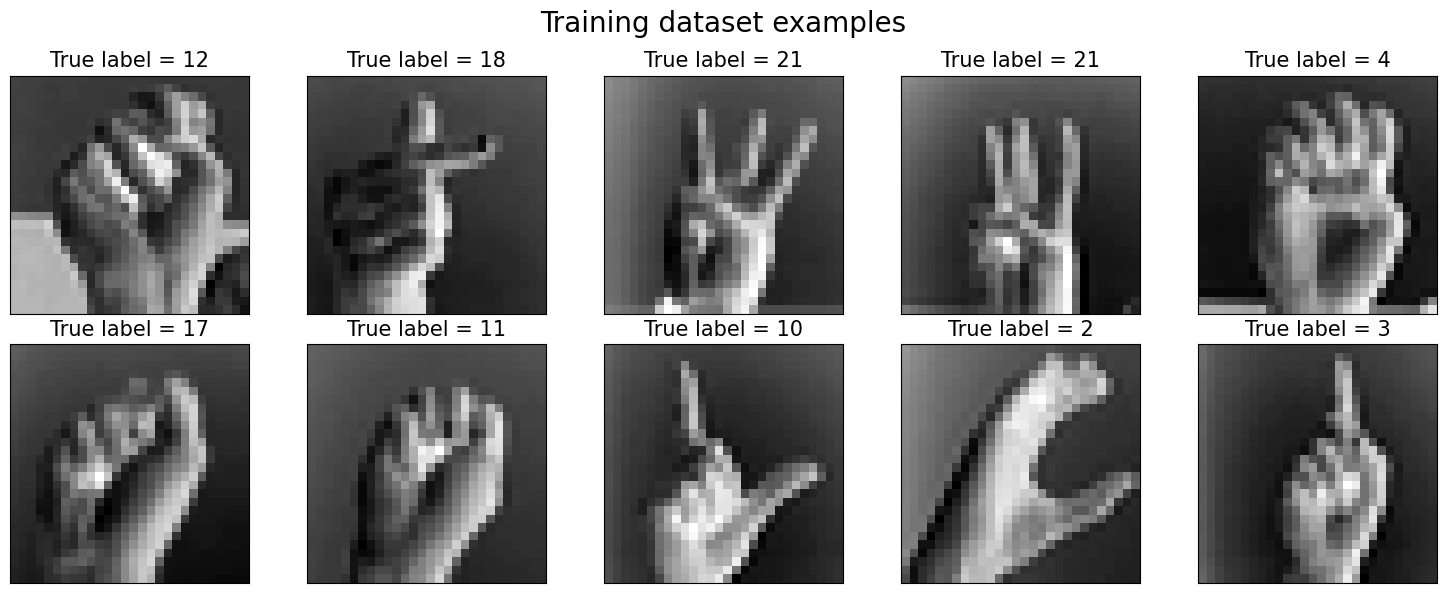

In [ ]:
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(training_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Training dataset examples", fontsize=20)
plt.tight_layout()
plt.show()

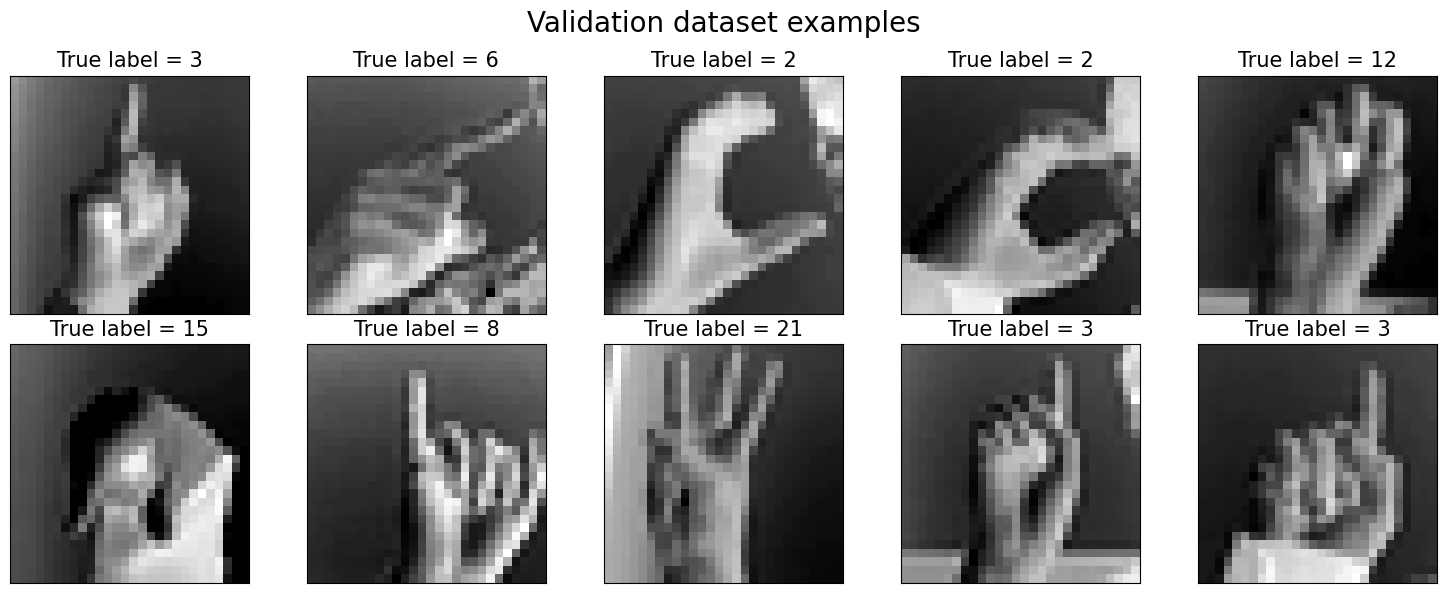

In [ ]:
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(validation_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Validation dataset examples", fontsize=20)
plt.tight_layout()
plt.show()

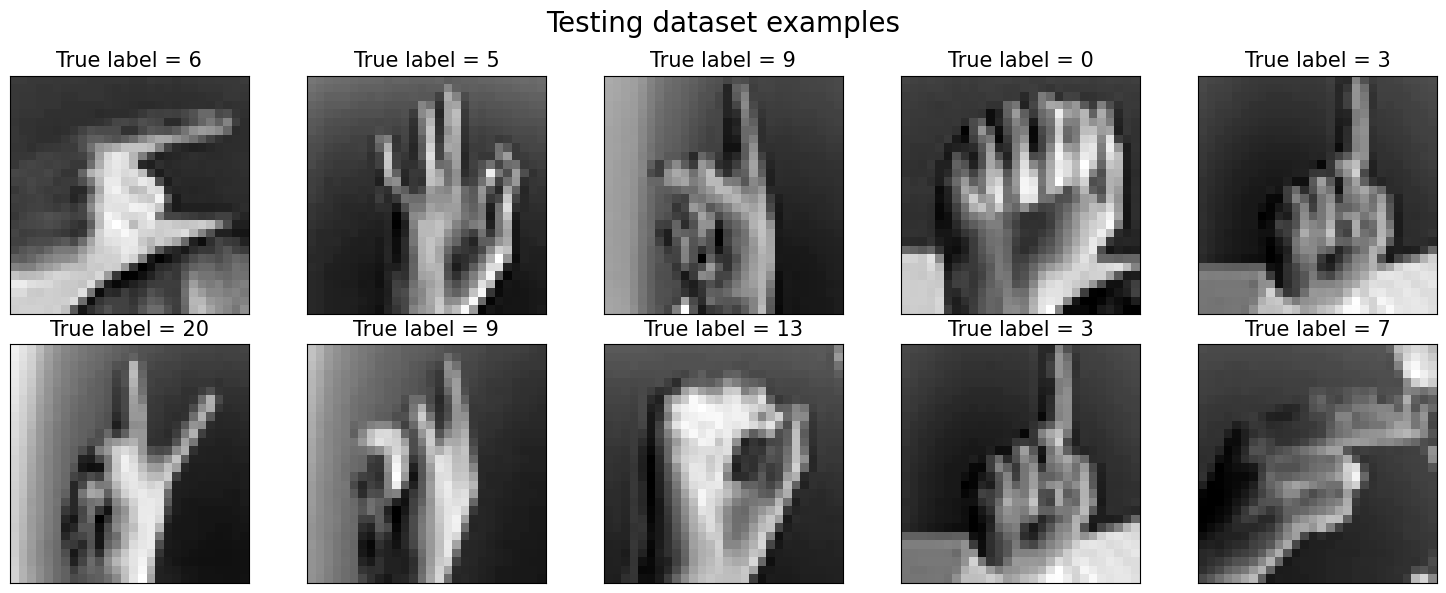

In [ ]:
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(testing_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Testing dataset examples", fontsize=20)
plt.tight_layout()
plt.show()

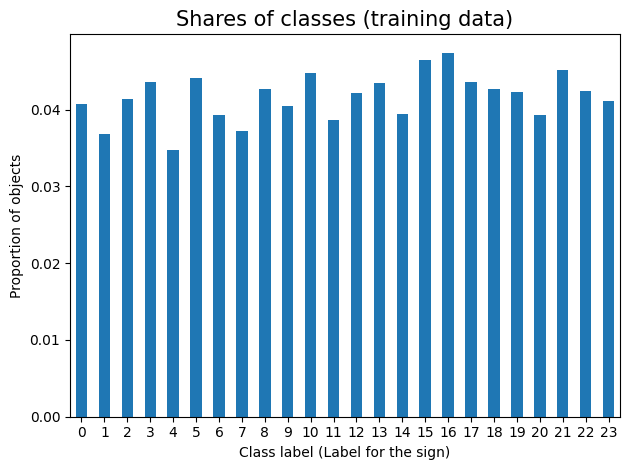

In [ ]:
training_labels = training_dataset[:][1].int()

unique_training_labels = np.unique(training_labels)

training_labels_count = np.bincount(training_labels)

n_train = training_labels.shape[0]

labels_info_share = pd.Series(
    training_labels_count, index=unique_training_labels
) / n_train

labels_info_share.plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Shares of classes (training data)", fontsize=15)
plt.xlabel("Class label (Label for the sign)")
plt.ylabel("Proportion of objects")
plt.tight_layout()
plt.show()


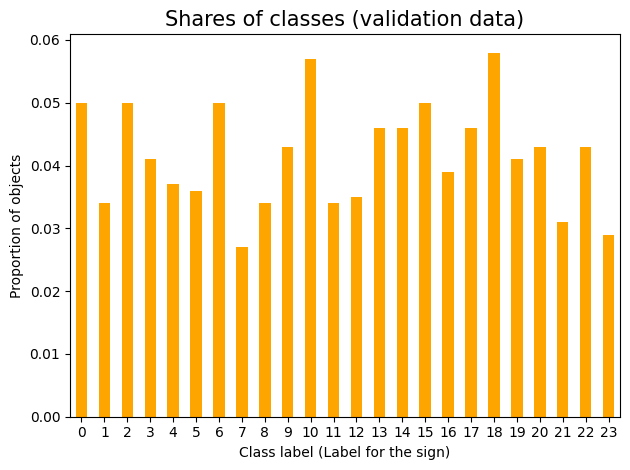

In [ ]:
validation_labels = validation_dataset[:][1].int()

unique_validation_labels = np.unique(validation_labels)

validation_labels_count = np.bincount(validation_labels)

n_valid = validation_labels.shape[0]

labels_info_share = pd.Series(
    validation_labels_count, index=unique_validation_labels
) / n_valid

labels_info_share.plot(kind="bar", color="orange")
plt.xticks(rotation=0)
plt.title("Shares of classes (validation data)", fontsize=15)
plt.xlabel("Class label (Label for the sign)")
plt.ylabel("Proportion of objects")
plt.tight_layout()
plt.show()

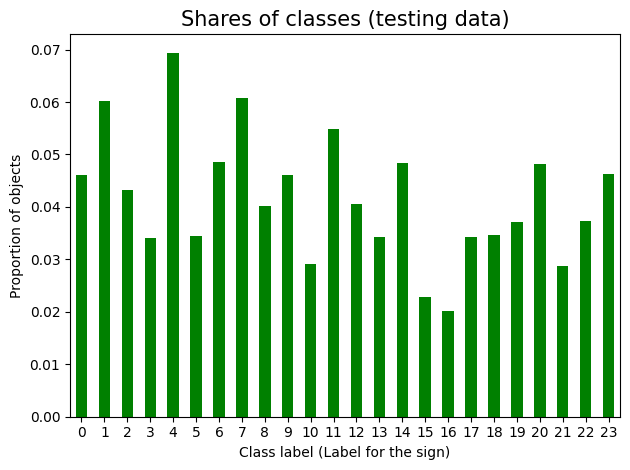

In [ ]:
testing_labels = testing_dataset[:][1].int()

unique_testing_labels = np.unique(testing_labels)

testing_labels_count = np.bincount(testing_labels)

n_test = testing_labels.shape[0]

labels_info_share = pd.Series(
    testing_labels_count, index=unique_testing_labels
) / n_test

labels_info_share.plot(kind="bar", color="green")
plt.xticks(rotation=0)
plt.title("Shares of classes (testing data)", fontsize=15)
plt.xlabel("Class label (Label for the sign)")
plt.ylabel("Proportion of objects")
plt.tight_layout()
plt.show()

In [ ]:
torch.manual_seed(RANDOM_SEED)

batch_size = 64

training_dataloader = DataLoader(
    training_dataset,
    batch_size=batch_size,
    shuffle=True,
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
)

testing_dataloader = DataLoader(
    testing_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
sign_mnist_classifier = nn.Sequential()


sign_mnist_classifier.add_module(
    "conv1",
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
    )

sign_mnist_classifier.add_module("relu1", nn.ReLU())


sign_mnist_classifier.add_module("pool1", nn.MaxPool2d(kernel_size=2))


sign_mnist_classifier.add_module(
    "conv2",
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
    )

sign_mnist_classifier.add_module("relu2", nn.ReLU())


sign_mnist_classifier.add_module("pool2", nn.MaxPool2d(kernel_size=2))


sign_mnist_classifier.add_module("flatten", nn.Flatten())


sign_mnist_classifier.add_module('fc1', nn.Linear(3136, 1024))

sign_mnist_classifier.add_module('relu3', nn.ReLU())


sign_mnist_classifier.add_module('dropout', nn.Dropout(p=0.5))


sign_mnist_classifier.add_module('fc2', nn.Linear(1024, 24))

In [ ]:
sign_mnist_classifier.eval()

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=24, bias=True)
)

In [ ]:
def train(
    model,
    loss_func,
    optimizer,
    training_dataloader,
    validation_dataloader,
    epochs=10,
    enable_logging=False,
    device=DEVICE,
):

    loss_history_train = [0] * epochs
    accuracy_history_train = [0] * epochs
    loss_history_valid = [0] * epochs
    accuracy_history_valid = [0] * epochs


    for epoch in range(epochs):


        model.train()


        for x_batch, y_batch in training_dataloader:


            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)


            model_predictions = model(x_batch)


            loss = loss_func(model_predictions, y_batch.long())


            loss.backward()


            optimizer.step()


            optimizer.zero_grad()


            loss_history_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (
                torch.argmax(model_predictions, dim=1) == y_batch
            ).float()
            accuracy_history_train[epoch] += is_correct.sum().cpu()


        loss_history_train[epoch] /= len(training_dataloader.dataset)
        accuracy_history_train[epoch] /= len(training_dataloader.dataset)


        model.eval()


        with torch.no_grad():


            for x_batch, y_batch in validation_dataloader:


                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)


                model_predictions = model(x_batch)


                loss = loss_func(model_predictions, y_batch.long())


                loss_history_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (
                    torch.argmax(model_predictions, dim=1) == y_batch
                ).float()
                accuracy_history_valid[epoch] += is_correct.sum().cpu()


        loss_history_valid[epoch] /= len(validation_dataloader.dataset)
        accuracy_history_valid[epoch] /= len(validation_dataloader.dataset)


        if enable_logging:
            print(
                "Epoch {}/{}\n"
                "train_loss = {:.4f}, train_accuracy = {:.4f} | "
                "valid_loss = {:.4f}, valid_accuracy = {:.4f}".format(
                epoch + 1,
                epochs,
                loss_history_train[epoch],
                accuracy_history_train[epoch],
                loss_history_valid[epoch],
                accuracy_history_valid[epoch],
                )
            )

    return (
        model,
        loss_history_train,
        accuracy_history_train,
        loss_history_valid,
        accuracy_history_valid,
    )

In [ ]:
sign_mnist_classifier = sign_mnist_classifier.to(DEVICE)

In [ ]:
loss_func = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(
    sign_mnist_classifier.parameters(), lr=learning_rate
)

In [ ]:
torch.manual_seed(RANDOM_SEED)

(
sign_mnist_classifier,
loss_history_train,
accuracy_history_train,
loss_history_valid,
accuracy_history_valid
) = train(
    model=sign_mnist_classifier,
    loss_func=loss_func,
    optimizer=optimizer,
    training_dataloader=training_dataloader,
    validation_dataloader=validation_dataloader,
    epochs=8,
    enable_logging=True,
)

Epoch 1/8
train_loss = 0.9533, train_accuracy = 0.7025 | valid_loss = 0.0878, valid_accuracy = 0.9830
Epoch 2/8
train_loss = 0.0709, train_accuracy = 0.9810 | valid_loss = 0.0092, valid_accuracy = 1.0000
Epoch 3/8
train_loss = 0.0197, train_accuracy = 0.9958 | valid_loss = 0.0031, valid_accuracy = 1.0000
Epoch 4/8
train_loss = 0.0147, train_accuracy = 0.9967 | valid_loss = 0.0109, valid_accuracy = 0.9980
Epoch 5/8
train_loss = 0.0116, train_accuracy = 0.9971 | valid_loss = 0.0017, valid_accuracy = 1.0000
Epoch 6/8
train_loss = 0.0097, train_accuracy = 0.9973 | valid_loss = 0.0001, valid_accuracy = 1.0000
Epoch 7/8
train_loss = 0.0107, train_accuracy = 0.9966 | valid_loss = 0.0016, valid_accuracy = 0.9990
Epoch 8/8
train_loss = 0.0082, train_accuracy = 0.9980 | valid_loss = 0.0001, valid_accuracy = 1.0000


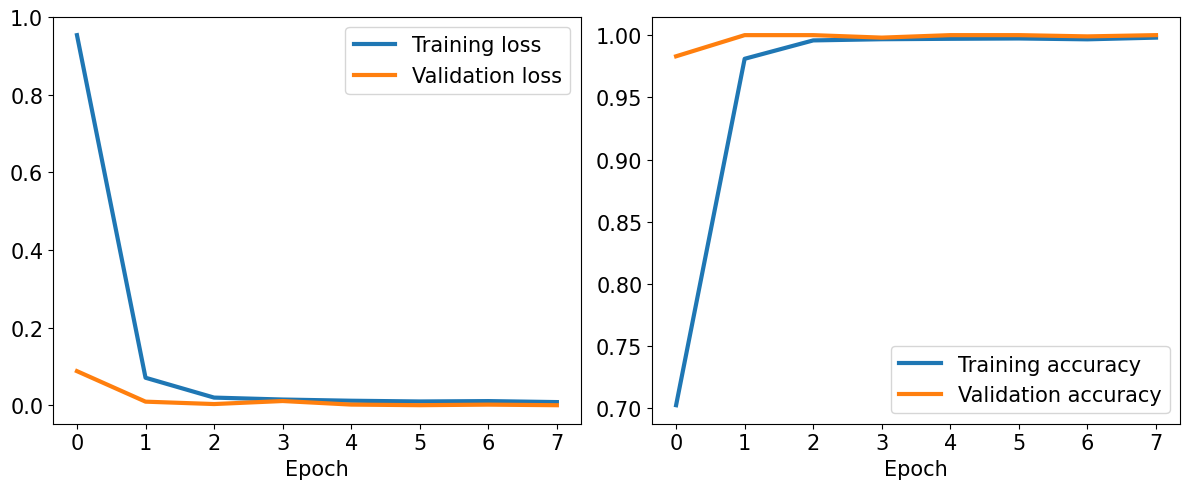

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history_train, lw=3)
ax.plot(loss_history_valid, lw=3)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(['Training loss', 'Validation loss'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_history_train, lw=3)
ax.plot(accuracy_history_valid, lw=3)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(['Training accuracy', 'Validation accuracy'], fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_test_by_batch(model, testing_dataloader, device=DEVICE):

    accuracy_test = 0

    test_predictions = []

    model.eval()

    with torch.no_grad():
        for x_batch, y_batch in testing_dataloader:

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            test_batch_predictions = torch.argmax(model(x_batch), dim=1)

            test_predictions.append(test_batch_predictions)

            is_correct = (test_batch_predictions == y_batch).float()
            accuracy_test += is_correct.sum().cpu()


    test_predictions_tensor = torch.cat(test_predictions).cpu()

    accuracy_test /= len(testing_dataloader.dataset)

    return accuracy_test, test_predictions_tensor

In [ ]:
accuracy_test, predictions_test = evaluate_test_by_batch(
    model=sign_mnist_classifier, testing_dataloader=testing_dataloader
)
print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.9484


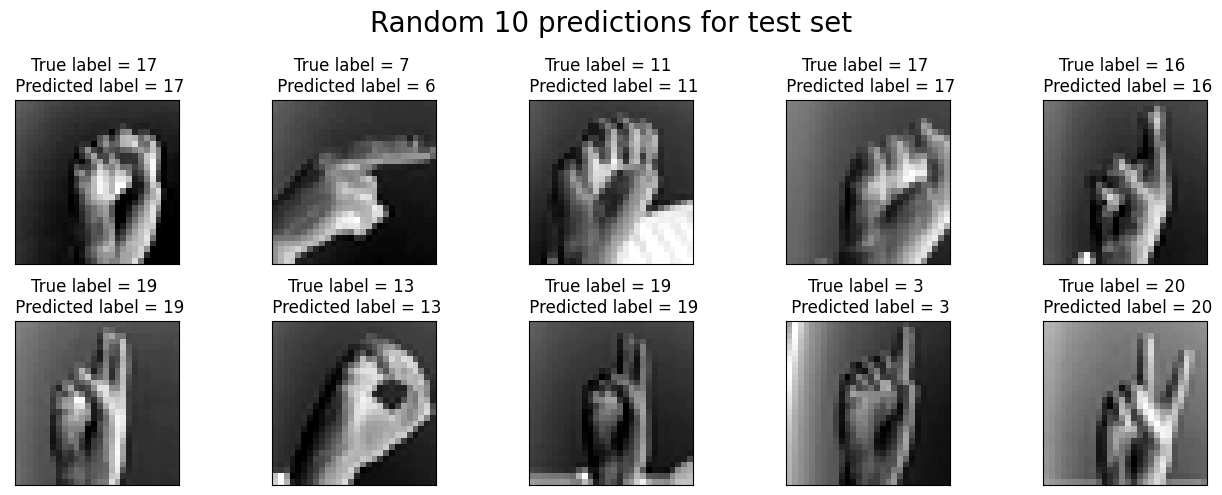

In [ ]:
nums = np.random.randint(low=0, high=x_test.shape[0], size=10)
fig = plt.figure(figsize=(13, 5))
for i, num in enumerate(nums):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_test[num].numpy().reshape(28, 28), cmap="gray_r")
    ax.set_title(f"True label = {y_test[num].int()} \n Predicted label = {predictions_test[num]}")
plt.suptitle("Random 10 predictions for test set", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
target_names = [
    "A", "B", "C", "D", "E", "F",
    "G", "H", "I", "K", "L", "M",
    "N", "O", "P", "Q", "R", "S",
    "T", "U", "V", "W", "X", "Y",
]

print(classification_report(
    y_true=y_test,
    y_pred=predictions_test,
    target_names=target_names,
)
     )

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       331
           B       1.00      1.00      1.00       432
           C       1.00      1.00      1.00       310
           D       1.00      1.00      1.00       245
           E       0.96      1.00      0.98       498
           F       0.93      1.00      0.96       247
           G       0.89      0.94      0.91       348
           H       0.98      0.91      0.94       436
           I       0.93      0.99      0.96       288
           K       0.92      0.87      0.89       331
           L       0.91      1.00      0.95       209
           M       1.00      0.89      0.94       394
           N       0.97      0.93      0.95       291
           O       1.00      0.96      0.98       246
           P       0.97      0.99      0.98       347
           Q       0.94      1.00      0.97       164
           R       0.88      0.83      0.85       144
           S       0.79    

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(45, kernel_size=(3,3), activation='relu', input_shape=(28,28,1), strides = 1, padding = 'same'))

model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same'))

model.add(Conv2D(55, kernel_size=(3,3), strides=1, padding='same', activation='relu'))

model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=24,activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 45)        450       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 45)        180       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 45)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 55)        22330     
                                                                 
 dropout (Dropout)           (None, 14, 14, 55)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 55)       

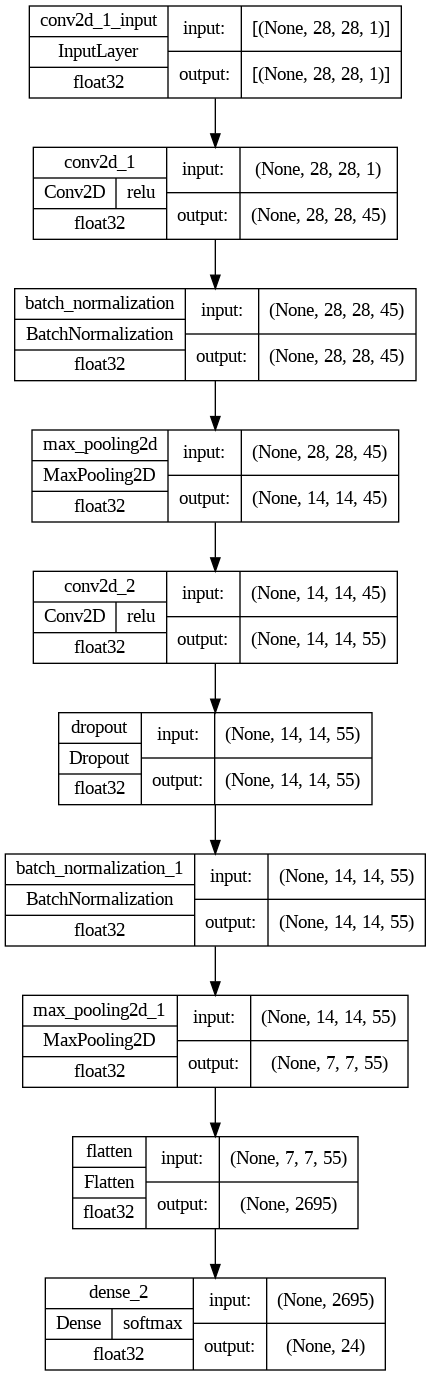

In [ ]:
model_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file,
                          show_shapes=True,
                          show_layer_activations=True,
                          show_dtype=True,
                          show_layer_names=True )

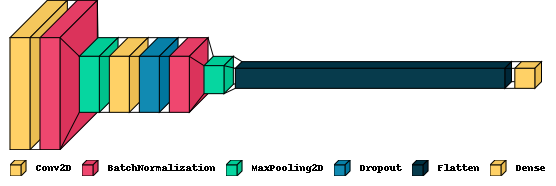

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend = True)